# testing otpimizations

<a href="https://colab.research.google.com/github/inspektral/onset-benchmark/blob/main/nmf-test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [1]:
import os

if 'google.colab' in str(get_ipython()):
    repo_name = 'onset-benchmark'
    repo_path = f'/content/{repo_name}'
    
    # Check if the current working directory is already the repo
    if os.getcwd() != repo_path:
        if not os.path.exists(repo_path):
            !git clone https://github.com/inspektral/onset-benchmark.git
        os.chdir(repo_path)  # Change to the repository directory
        !pip install -r requirements.txt  # Install dependencies
        !git clone https://github.com/inspektral/music2latent.git

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import synth
from IPython.display import Audio, display
import librosa

import utils
import test_signals


2025-07-03 16:44:30.764738: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-03 16:44:30.930437: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-03 16:44:30.958918: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-03 16:44:30.973016: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-03 16:44:31.167329: I tensorflow/core/platform/cpu_feature_guar

In [3]:
tests = test_signals.get_tests()
print(f"{len(tests)} tests found:")
for key in tests.keys():
    print(f"{key}")

print("available metrics:")
print(utils.get_available_metrics())

print("available representations:")
print(utils.get_available_representations())

13 tests found:
square_slow
square_fast
square_vibrato
saw_noise
sines_noise
filter_saw
triangle_clip
fm_amplitude
fm_frequency
delay_noise
delay_saw
reverb_noise
reverb_saw
available metrics:
['magnitude', 'distances', 'cosine_similarity']
available representations:
['mfcc', 'cqt', 'spectrum', 'music2latent', 'dac']


In [4]:
TEST = "fm_frequency"
REPR = "music2latent"
METRIC = "magnitude"

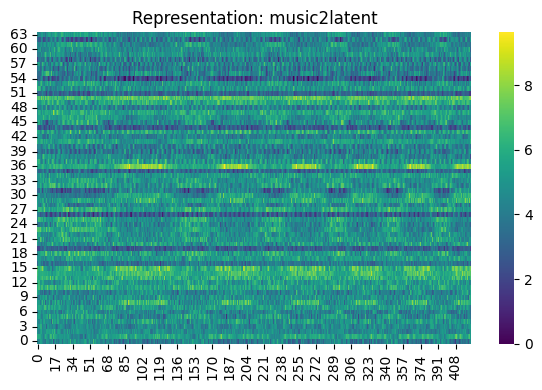

In [5]:
audio, modulator = tests[TEST]()
length = int(len(modulator) / 10)

def norm_stretch(arr, length):
    arr = utils.norm(arr)
    arr = utils.stretch_array(arr, length)
    return arr

modulator = norm_stretch(modulator, length)
repr = utils.calc_representation(audio, REPR)
minimum = np.abs(np.min(repr))
repr = repr + minimum

# NMF
import librosa

components, activations = librosa.decompose.decompose(
    repr,
    n_components=4,
    sort=True,
    random_state=42
)

display(Audio(audio, rate=44100))

utils.plot_heatmap(
    repr,
    title=f"Representation: {REPR}",
    small=True
)

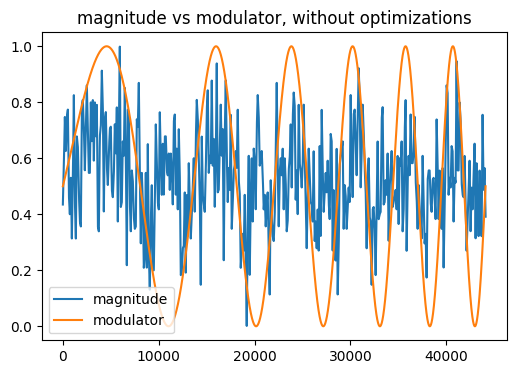

In [6]:
metric = utils.calc_metric(repr, METRIC)
metric = utils.norm_stretch(metric, length)

plt.figure(figsize=(6,4))
plt.plot(metric, label=METRIC)
plt.plot(modulator, label='modulator')
plt.title(f'{METRIC} vs modulator, without optimizations')
plt.legend()
plt.show()

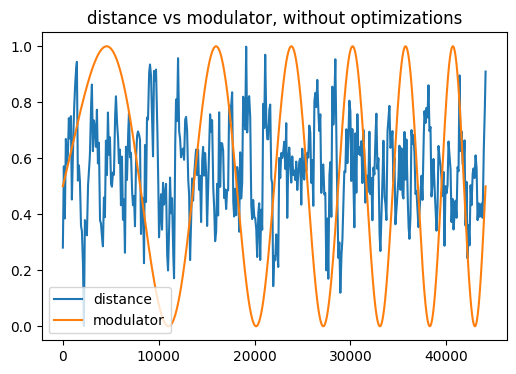

In [7]:
distance = utils.calc_metric(repr, "distances")
distance = utils.norm_stretch(distance, length)

plt.figure(figsize=(6,4))
plt.plot(distance, label="distance")
plt.plot(modulator, label='modulator')
plt.title(f'distance vs modulator, without optimizations')
plt.legend()
plt.show()

Best smooth: 2913
Best exponent: 0.7864069521445256
Correlation between modulator and magnitude: 0.7878


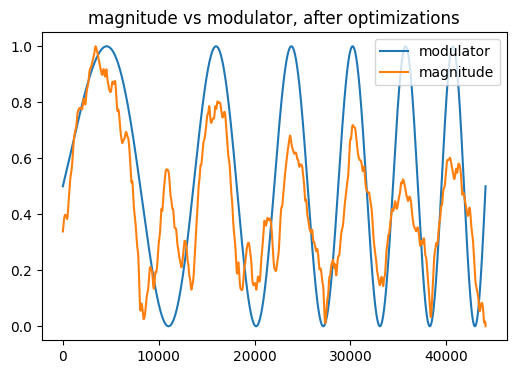

In [8]:
best_smooth = utils.calc_best_smoothing(metric, modulator)
print(f"Best smooth: {best_smooth}")
metric = utils.norm(utils.smooth(metric, best_smooth))

best_exponent = utils.calc_best_exponent(metric, modulator)
print(f"Best exponent: {best_exponent}")
metric = utils.norm(metric ** best_exponent)

correlation = utils.calc_correlation(modulator, metric)
print(f"Correlation between modulator and magnitude: {correlation:.4f}")

plt.figure(figsize=(6,4))
plt.plot(modulator, label='modulator')
plt.plot(metric, label=METRIC)
plt.title(f'{METRIC} vs modulator, after optimizations')
plt.legend()
plt.show()



Activation 0 correlation: 0.9362
Activation 1 correlation: 0.4924
Activation 2 correlation: -0.9421
Activation 3 correlation: 0.7219
Best activation index: 2 with correlation 0.9421


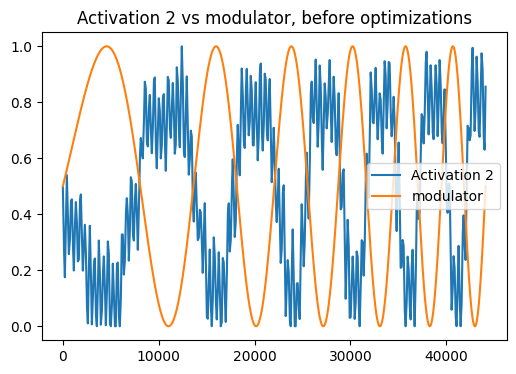

In [9]:
correlations = []

for i in range(activations.shape[0]):
    activation = norm_stretch(activations[i], length)
    activation = utils.smooth(activation, best_smooth)
    activation = norm_stretch(activation, length)
    correlation = utils.calc_correlation(modulator, activation)
    correlations.append(np.abs(correlation))
    print(f"Activation {i} correlation: {correlation:.4f}")

best_index = np.argmax(correlations)
print(f"Best activation index: {best_index} with correlation {correlations[best_index]:.4f}")
activation = norm_stretch(activations[best_index], length)



plt.figure(figsize=(6,4))
plt.plot(activation, label=f'Activation {best_index}')
plt.plot(modulator, label='modulator')
plt.title(f'Activation {best_index} vs modulator, before optimizations')
plt.legend()
plt.show()

Best smooth for activation 2: 1965
Correlation between modulator and activation 2: -0.9521


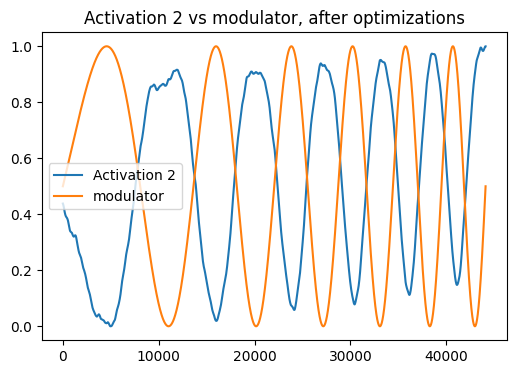

In [10]:
best_smooth = utils.calc_best_smoothing(activation, modulator)
print(f"Best smooth for activation {best_index}: {best_smooth}")
activation = utils.norm(utils.smooth(activation, best_smooth))
correlation = utils.calc_correlation(modulator, activation)
print(f"Correlation between modulator and activation {best_index}: {correlation:.4f}")


plt.figure(figsize=(6,4))
plt.plot(activation, label=f'Activation {best_index}')
plt.plot(modulator, label='modulator')
plt.title(f'Activation {best_index} vs modulator, after optimizations')
plt.legend()
plt.show()



numpy.float16

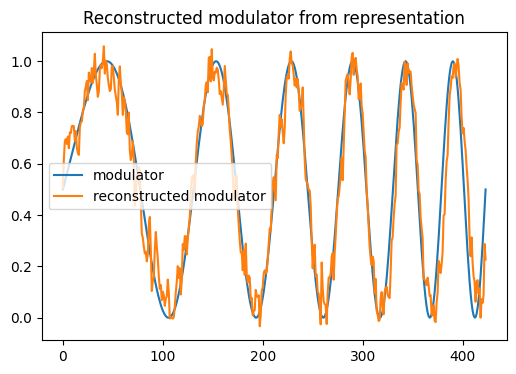

[ 0.02541533 -0.04703343 -0.01683556 -0.00686986  0.00103048  0.0169552
  0.06362176  0.0095957  -0.07954817  0.00783793 -0.07223731 -0.09309522
  0.0640259   0.00344947  0.01854582 -0.05361039 -0.04676723  0.01686517
 -0.02999508  0.03694644 -0.01303736 -0.0389937   0.03622621  0.01721657
  0.01485835  0.02078487  0.0093586   0.00957084 -0.0178711  -0.06990004
  0.02686958  0.0110089   0.032942    0.02689072  0.01272194 -0.01094125
 -0.03198171 -0.01045729  0.03342654  0.04582593 -0.02481228 -0.03564663
  0.01234115  0.0753519   0.05320394 -0.00145505 -0.03715245 -0.00813019
  0.10658717 -0.01166877  0.03508181  0.02257863 -0.04519307 -0.01501775
  0.03674113 -0.02023419  0.01226164  0.04461563  0.01449552 -0.06977585
  0.01852489  0.11559599  0.03330867  0.01025159]
61 with value 0.1156 is the most important component


In [19]:
repr_T = repr.T
repr_T = repr_T.astype(np.float32)
mod_repr_sized = utils.norm_stretch(modulator, repr_T.shape[0])

w, residuals, rank, singular_values = np.linalg.lstsq(
    repr_T,
    mod_repr_sized,
    rcond=None
)

plt.figure(figsize=(6,4))
plt.plot(mod_repr_sized, label='modulator')
plt.plot(repr_T @ w, label='reconstructed modulator')
plt.title('Reconstructed modulator from representation')
plt.legend()
plt.show()

print(w)
print(f"{np.argmax(np.abs(w))} with value {np.max(np.abs(w)):.4f} is the most important component")
